# Feature Engineering V2

## 1.Environment Setup

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(42)
random.seed(42)
print("Seed: 42")

Seed: 42


## 2.Data Processing

In [ ]:
# https://drive.google.com/file/d/16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju/view?usp=sharing
!gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju

Downloading...
From: https://drive.google.com/uc?id=16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju
To: /content/cleveland.csv
100% 10.9k/10.9k [00:00<00:00, 25.1MB/s]


In [ ]:
DATA_PATH = 'cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

K_features = 10

raw = pd.read_csv(DATA_PATH, header=None)
raw.columns = COLUMNS

for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')


raw['target'] = (raw['target'] > 0).astype(int)
print("Shape:", raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


## 3.Data Post-processing

In [ ]:
TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]

X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])
num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols),
    ('cat', cat_proc, categorical_cols),
])
raw_pipeline = Pipeline([
    ('preprocess', preprocess),
])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)


## 4.Processed Dataset (Raw Dataset)

In [ ]:
preprocessed_feature_names = []
for name, transformer, columns in preprocess.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        preprocessed_feature_names.extend(columns)

X_raw_train_df = pd.DataFrame(
    X_raw_train, columns=preprocessed_feature_names, index=X_train.index)
X_raw_val_df = pd.DataFrame(
    X_raw_val, columns=preprocessed_feature_names, index=X_val.index)
X_raw_test_df = pd.DataFrame(
    X_raw_test, columns=preprocessed_feature_names, index=X_test.index)

out_dir = Path('splits'); out_dir.mkdir(parents=True, exist_ok=True)
pd.concat([X_raw_train_df, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_train.csv', index=False)
pd.concat([X_raw_val_df, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_val.csv', index=False)
pd.concat([X_raw_test_df, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_test.csv', index=False)

display(X_raw_train_df)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
180,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0
208,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0
167,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0
105,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0
297,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.829818,0.514117,2.733557,0.310836,0.179210,0.0,1.000000,0.0,1.0,0.0,0.5,0.000000,0.0
136,1.720848,0.798433,-1.438042,-1.102621,1.428521,1.0,1.000000,0.0,0.0,1.0,1.0,0.000000,1.0
2,1.386712,-0.623144,-0.395142,-0.925938,1.428521,1.0,1.000000,0.0,1.0,1.0,0.5,0.666667,1.0
189,1.609469,0.514117,0.078903,-0.175039,0.893102,1.0,0.666667,0.0,1.0,0.0,0.5,1.000000,1.0


## 5.Decision Tree Feature Selection

In [ ]:
dt_feature_selection_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

In [ ]:
dt_feature_selection_pipeline.fit(X_train, y_train)
feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=preprocessed_feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

print("Sorted Feature Importances:")
display(sorted_feature_importances)

Sorted Feature Importances:


,0
thal,0.292921
cp,0.126362
ca,0.118425
oldpeak,0.109681
chol,0.097347
age,0.074188
thalach,0.073157
sex,0.033909
slope,0.025014
exang,0.015216


In [ ]:
selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f"Top {K_features} selected features:")
print(selected_features)

Top 10 selected features:
['thal', 'cp', 'ca', 'oldpeak', 'chol', 'age', 'thalach', 'sex', 'slope', 'exang']


In [ ]:
X_dt_train = X_raw_train_df[selected_features]
X_dt_val = X_raw_val_df[selected_features]
X_dt_test = X_raw_test_df[selected_features]

print("Head of X_dt_train:")
display(X_dt_train.head())
print("\nShape of X_dt_train:", X_dt_train.shape)

Head of X_dt_train:


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang
180,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0
208,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0
167,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0
105,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0
297,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0



Shape of X_dt_train: (242, 10)


In [ ]:
pd.concat([X_dt_train, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_train.csv', index=False)
pd.concat([X_dt_val, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_val.csv', index=False)
pd.concat([X_dt_test, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_test.csv', index=False)

print(f"Saved RAW_DT splits. K (RAW_DT features) = {K_features}")
X_dt_train

Saved RAW_DT splits. K (RAW_DT features) = 10


,thal,cp,ca,oldpeak,chol,age,thalach,sex,slope,exang
180,1.0,1.000000,0.000000,-0.445445,0.458139,-0.729485,0.708371,1.0,0.5,0.0
208,0.0,0.333333,0.000000,-0.891627,0.230598,0.050166,0.222495,1.0,0.0,0.0
167,0.0,0.333333,0.333333,-0.891627,0.723605,-0.061212,0.399178,0.0,0.0,1.0
105,1.0,0.333333,0.000000,-0.891627,1.121803,-0.061212,0.266666,1.0,0.0,0.0
297,1.0,1.000000,0.000000,-0.713154,-0.167601,0.272924,-1.190962,0.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...
173,0.0,1.000000,0.000000,0.179210,2.733557,0.829818,0.310836,0.0,0.5,0.0
136,1.0,1.000000,0.000000,1.428521,-1.438042,1.720848,-1.102621,1.0,1.0,1.0
2,1.0,1.000000,0.666667,1.428521,-0.395142,1.386712,-0.925938,1.0,0.5,1.0
189,1.0,0.666667,1.000000,0.893102,0.078903,1.609469,-0.175039,1.0,0.5,0.0


## 6.Feature Engineering

In [ ]:
def add_new_features_func(df):
    df = df.copy()
    if {'chol','age'} <= set(df.columns):
        df['chol_per_age'] = df['chol']/df['age']
    if {'trestbps','age'} <= set(df.columns):
        df['bps_per_age'] = df['trestbps']/df['age']
    if {'thalach','age'} <= set(df.columns):
        df['hr_ratio'] = df['thalach']/df['age']
    if 'age' in df.columns:
        df['age_bin'] = pd.cut(
            df['age'], bins=5, labels=False
        ).astype('category')
    return df

gen_num = ['chol_per_age','bps_per_age','hr_ratio']
gen_cat = ['age_bin']
all_nums = [c for c in numeric_cols] + gen_num
all_cats = [c for c in categorical_cols] + gen_cat

class AddNewFeaturesTransformer(
    BaseEstimator,
    TransformerMixin
):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.columns_ = X.columns
        self.new_features_ = []
        if {'chol','age'} <= set(X.columns):
             self.new_features_.append('chol_per_age')
        if {'trestbps','age'} <= set(X.columns):
             self.new_features_.append('bps_per_age')
        if {'thalach','age'} <= set(X.columns):
             self.new_features_.append('hr_ratio')
        if 'age' in X.columns:
             self.new_features_.append('age_bin')
        return self

    def transform(self, X):
        return add_new_features_func(X)

    def get_feature_names_out(self, input_features=None):
        return list(self.columns_) + self.new_features_


num_proc = Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('sc',  StandardScaler())])
cat_proc = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore',
                                           sparse_output=False))])
pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pre = Pipeline([
    ('add', AddNewFeaturesTransformer()),
    ('pre', pre),
]).set_output(transform='pandas')

Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]
Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]

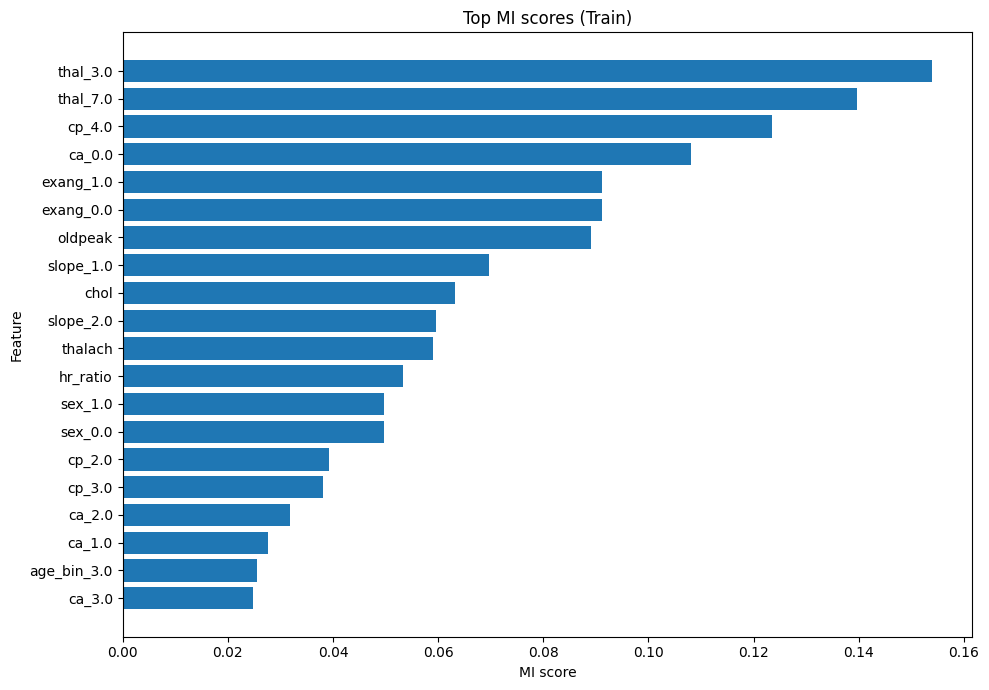

Saved FE splits. K (FE features) = 13


,fe_topk_features
0,thal_3.0
1,thal_7.0
2,cp_4.0
3,ca_0.0
4,exang_1.0
5,exang_0.0
6,oldpeak
7,slope_1.0
8,chol
9,slope_2.0


In [ ]:
ohe = fe_pre.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(all_cats))
is_discrete = np.array(
    [c in cat_names for c in Xt_tr.columns],
    dtype=bool
)
mi = mutual_info_classif(Xt_tr.values, y_train.values,
                         discrete_features=is_discrete,
                         random_state=42)
mi_series = pd.Series(
    mi, index=Xt_tr.columns).sort_values(ascending=False)

N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]
plt.figure(figsize=(10, max(6, 0.35*N)))
plt.barh(topN.index, topN.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('top_mi_scores.pdf', bbox_inches='tight')
plt.show()

K = raw.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)

fe_tr = Xt_tr[topk_cols].assign(target=y_train.values)
fe_va = Xt_va[topk_cols].assign(target=y_val.values)
fe_te = Xt_te[topk_cols].assign(target=y_test.values)

out = Path('splits'); out.mkdir(parents=True, exist_ok=True)
fe_tr.to_csv(out/'fe_train.csv', index=False)
fe_va.to_csv(out/'fe_val.csv', index=False)
fe_te.to_csv(out/'fe_test.csv', index=False)

display(pd.Series(
    topk_cols, name='fe_topk_features'
).reset_index(drop=True))

In [ ]:
display(fe_tr.head())

,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
180,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,0.458139,1.0,0.708371,0.726265,1.0,1
208,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.230598,0.0,0.222495,-0.054469,1.0,0
167,1.0,0.0,0.0,0.0,1.0,0.0,-0.891627,1.0,0.723605,0.0,0.399178,0.099522,0.0,0
105,0.0,1.0,0.0,1.0,0.0,1.0,-0.891627,1.0,1.121803,0.0,0.266666,0.031766,1.0,0
297,0.0,1.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.167601,1.0,-1.190962,-0.859761,0.0,1


## 7.Decision Tree on Feature Engineering Dataset

In [ ]:
dt_fe_feature_selection_pipeline = Pipeline([
    ('preprocess', fe_pre),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

In [ ]:
dt_fe_feature_selection_pipeline.fit(X_train, y_train)
pipeline_feature_names = dt_fe_feature_selection_pipeline.named_steps['preprocess'].get_feature_names_out()
feature_importance_series = pd.Series(
    dt_fe_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=pipeline_feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
print("Sorted Feature Importances:")
display(sorted_feature_importances)

Sorted Feature Importances:


,0
thal_3.0,0.292921
cp_4.0,0.117949
ca_0.0,0.105388
chol_per_age,0.079216
hr_ratio,0.065967
oldpeak,0.051972
chol,0.048993
age,0.033717
exang_0.0,0.029085
cp_3.0,0.025796


In [ ]:
selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f"Top {K_features} selected features:")
print(selected_features)

Top 10 selected features:
['thal_3.0', 'cp_4.0', 'ca_0.0', 'chol_per_age', 'hr_ratio', 'oldpeak', 'chol', 'age', 'exang_0.0', 'cp_3.0']


In [ ]:
X_fe_dt_train = Xt_tr[selected_features]
X_fe_dt_val = Xt_va[selected_features]
X_fe_dt_test = Xt_te[selected_features]

print("Head of X_fe_dt_train:")
display(X_fe_dt_train.head())
print("\nShape of X_fe_dt_train:", X_fe_dt_train.shape)

Head of X_fe_dt_train:


,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0
180,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0
208,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0
167,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0
105,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0
297,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0



Shape of X_fe_dt_train: (242, 10)


In [ ]:
pd.concat([X_fe_dt_train, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_train.csv', index=False)
pd.concat([X_fe_dt_val, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_val.csv', index=False)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_test.csv', index=False)

print(f"Saved FE_DT splits. K (FE features) = {K_features}")

Saved FE_DT splits. K (FE features) = 10


In [ ]:
X_fe_dt_train

,thal_3.0,cp_4.0,ca_0.0,chol_per_age,hr_ratio,oldpeak,chol,age,exang_0.0,cp_3.0
180,0.0,1.0,1.0,0.952258,0.726265,-0.445445,0.458139,-0.729485,1.0,0.0
208,1.0,0.0,1.0,0.082082,-0.054469,-0.891627,0.230598,0.050166,1.0,0.0
167,1.0,0.0,0.0,0.606839,0.099522,-0.891627,0.723605,-0.061212,0.0,0.0
105,0.0,0.0,1.0,0.965051,0.031766,-0.891627,1.121803,-0.061212,1.0,0.0
297,0.0,1.0,1.0,-0.411237,-0.859761,-0.713154,-0.167601,0.272924,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
173,1.0,1.0,1.0,1.547765,-0.403184,0.179210,2.733557,0.829818,1.0,0.0
136,0.0,1.0,1.0,-2.016150,-1.313675,1.428521,-1.438042,1.720848,0.0,0.0
2,0.0,1.0,0.0,-1.157488,-1.143346,1.428521,-0.395142,1.386712,0.0,0.0
189,0.0,0.0,0.0,-0.915005,-0.910927,0.893102,0.078903,1.609469,1.0,1.0


In [ ]:
# zip folder
!zip -r dataset.zip splits

  adding: splits/ (stored 0%)
  adding: splits/dt_val.csv (deflated 67%)
  adding: splits/dt_test.csv (deflated 66%)
  adding: splits/dt_train.csv (deflated 80%)
  adding: splits/fe_test.csv (deflated 64%)
  adding: splits/fe_val.csv (deflated 64%)
  adding: splits/fe_dt_train.csv (deflated 69%)
  adding: splits/raw_train.csv (deflated 81%)
  adding: splits/fe_dt_test.csv (deflated 60%)
  adding: splits/fe_dt_val.csv (deflated 61%)
  adding: splits/fe_train.csv (deflated 74%)
  adding: splits/raw_val.csv (deflated 67%)
  adding: splits/raw_test.csv (deflated 67%)
